In [3]:
import os #os 모듈: 파일이나 디렉토리 조작

base_path = r'C:\Users\boo\Desktop\project\example\New_Sample\{}\{}_Hazy\Hazy\Day' # \로 작성시 unicode 에러 발생, /로 작성해야 함
image_path = base_path.format('원천데이터', 'TS') # .format : 문자열 중간에 특정 변수값 대입 -> {}에 format 함수 인자 대입
label_path = base_path.format('라벨링데이터', 'TL')

cameras = ('Back', 'Front', 'IR', 'Left', 'Right')
# [a, b, c] : list , (a, b, c) : 튜플 
# 튜플은 list와 거의 비슷하지만, 튜플은 list와 달리 요소값을 변화시킬 수 없다.
lidars = ('Lidar_Center', 'Lidar_Left', 'Lidar_Right')

FRAME_IDX = 1

## Camera

In [7]:
import cv2
import json
import numpy as np

LABEL_TYPE = 'polygon'

POLYGON_ISCLOSED = True
POLYGON_COLOR = (255, 0, 0)
POLYGON_THICKNESS = 2

BBOX_COLOR = (255, 0, 0)
BBOX_THICKNESS = 2


def draw_label_on_image(image: np.ndarray, points: np.ndarray, label_type:str = 'polygon'):
    #np.ndarray : n차원 배열의 자료형
    #def 함수명(변수1 : 변수1의 자료형 = 변수1의 default 값 , ~~) -> return값 자료형 :
    assert label_type in ('polygon', 'bbox'), "Unknown label_type: {}".format(label_type)
    # assert 조건식, "오류 메세지"
    # -> 조건식이 True면 다음 명령어로 진행, 조건식이 False면 프로그램 중단 후 오류 메세지 print 
    # in, not in 연산
    # a in b : a 값이 b 리스트 안에 있다면 True, 없으면 False / not in 은 반대 

    if label_type == 'polygon':    
        points = points.reshape((-1, 1, 2))
        # np.reshape(변경할 배열, 차원) or 변경할 배열.reshape(차원)
        # -1의 의미: 원래 배열의 길이와 남은 차원으로 부터 추정
        # ex) list = [1, 2, 3, 4, 5, 6, 7, 8]
        #     list.reshape(-1,1,2)
        #     >> [[[1, 2]], [[3, 4]], [[5, 6]], [[7, 8]]]
        #     list.reshape(-1,2,1)
        #     >> [[[1], [2]], [[3], [4]], [[5], [6]], [[7], [8]]]
        image = cv2.polylines(image, [points], POLYGON_ISCLOSED, POLYGON_COLOR, POLYGON_THICKNESS)
        # cv2.polylines(원본그림, 좌표리스트, 마지막점과 첫점 연결 여부, 선색, 선 굵기) : 다각형 그리기
         
    else:
        x1, y1 = np.min(points, axis=0)
        x2, y2 = np.max(points, axis=0)
        # np.min(), np.max() 배열의 최소값,최대값 구하기
        # np.min(배열) >> 배열 전체에서 최소값
        # np.min(배열, axis = 0 or 1) >> 0: 배열의 각 열의 최솟값, 1: 각 행의 최솟값

        image = cv2.rectangle(image, (x1, y1), (x2, y2), BBOX_COLOR, BBOX_THICKNESS) 
        # cv2.rectangle(원본그림, 시작점좌표, 종료점좌표, 선색, 선 굵기, 선 종류, shift) : 직사각형 그리기
        # 선 굵기 = -1 이면 채워진 사각형
    
    return image


def get_image_with_annotations(label_filename: str, image_path: str):
    with open(label_filename, 'r') as f:
    # with open(파일명, '모드') as 불러온파일변수:
    # -> with 구문이 끝나면 자동으로 파일 close
    # 'r' : 읽기 , 'w' : 쓰기 , 'a' : 추가
        label = json.load(f)
        # json : JavaScript Object Notation의 약자로서 데이터를 문자열의 형태로 나타내기 위해서 사용
        # json.loads() : json 문자열을 python 객체로 변환

    *_, scene, camera, _ = label_filename.split('\\')
    # 문자열.split('구분자',분활 횟수) : 문자열을 구분자에 따라 앞에서 부터 분활 횟수만큼 나눈다, 분활 횟수 없으면 모두 나눈다
    # ex) str = 'a/b/c/d/e/f'
    #     str.split('/',3)
    #     >> ['a', 'b', 'c', 'd/e/f']
    # *_ : 여러개의 값 무시 , _ : 값 무시
    # 즉 *_, scene, camera, _ 의 의미는 분활된 문자열의 마지막에서 2번째와 3번째 단어를 camera와 scene에 저장 

    image_filename = os.path.join(image_path, camera, label['imagePath'])
    # print(image_filename)
    # os.path.join(a, b, c) >> a\b\c : 파라미터들을 합쳐 경로로 만들어준다.
    
    image = Image.open(image_filename) 
    # Image.open(겅로) : 이미지 열기    
    image_np = np.array(image)
    # np.array(image) : PIL 이미지를 NumPy array로 변환

    for shape in label['shapes']:
        point_np = np.array(shape['points'], np.int32)
        image_np = draw_label_on_image(image_np, point_np, label_type=LABEL_TYPE)

    return image_np


def aggregate_images(images):
    images_agg = []

    min_height = min(img.shape[0] for img in images)
    # 이미지.shape >> (높이, 너비, 채널) : 이미지 크기 구하기
    for image in images:
        height, width = image.shape[:2]
        ratio = min_height / height
        images_agg.append(cv2.resize(image, None, None, fx=ratio, fy=ratio))  
        # .append : list에 새로운 요소 추가
        # cv2.resize(img, dsize=(가로,세로), fx=가로사이즈배수, fy=세로사이즈배수, interpolation=보간법 )
        # dsize에 값을 넣으면 그 크기로 사이즈 변경 / fx, fy에 값을 넣으면 그 크기 비율로 사이즈 변경      
    
    return np.hstack(images_agg)
    # np.hstack : 가로로 행렬결합 (행 개수가 일치해야 함) / np.vstack : 세로로 행렬 결합 (열 개수가 일치해야 함)
    # ex) a = [[0 1 2]   b = [[6 7 8]        np.hstack(a, b) >> [[0 1 2 6 7 8]     np.vstack(a,b) >> [[0 1 2]
    #          [3 4 5]]       [9 10 11]]                         [3 4 5 9 10 11]]                     [3 4 5]
    #                                                                                                 [6 7 8]
    #                                                                                                 [9 10 11]]

C:\Users\boo\Desktop\project\example\New_Sample\라벨링데이터\TL_Hazy\Hazy\Day\Right\85CR_HD_20211216_037237.json


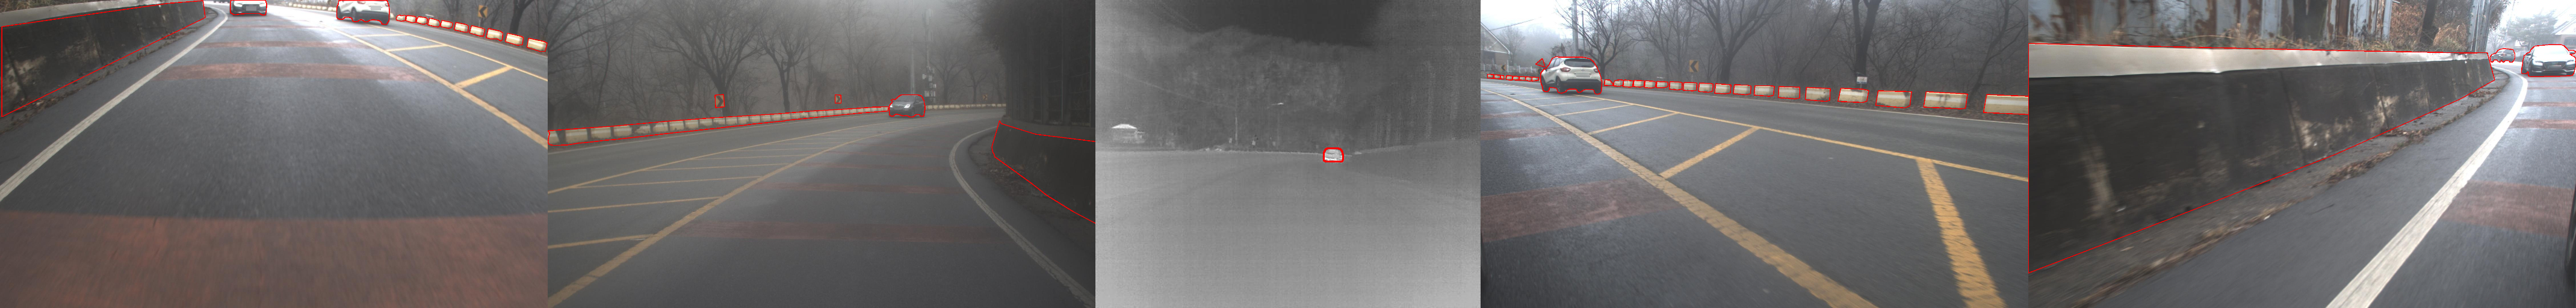

In [9]:
import glob
from PIL import Image

images = []
for camera in cameras:
    #print(camera)
    label_filename = sorted(glob.glob(os.path.join(label_path, camera, '*.json')))[FRAME_IDX]
    # print(label_filename)
    # sorted() : list 정렬
    # glob.glob('dir/*.json') : dir 디렉토리에 있는 모든 json 파일들의 리스트를 봔환
    images.append(get_image_with_annotations(label_filename, image_path))
    # .append : list에 새로운 요소 추가

print(label_filename)

frame = aggregate_images(images)
Image.fromarray(frame)
# Image.gromarray() : NumPy array를 PIL 이미지로 변환

In [19]:
## Create Video
import cv2
from tqdm import tqdm

# Get FrameSize
def get_frame(idx):
    images = []
    for camera in cameras:
        label_filename = sorted(glob.glob(os.path.join(label_path, camera, '*.json')))[idx]
        images.append(get_image_with_annotations(label_filename, image_path))
    frame = aggregate_images(images)
    return frame


frame = get_frame(0)

fourcc = cv2.VideoWriter_fourcc(*'mp4s')
# fourcc : 동영상 파일의 코덱, 압축 방식, 색상, 픽셀 포맷 등을 정의하는 정수 값
fps = 5
frameSize = (frame.shape[1], frame.shape[0])
filename = label_path.replace('/', '_') + '.mp4'

vid = cv2.VideoWriter(filename, fourcc, fps, frameSize)
# 비디오 파일 저장하기



num_frames = len(glob.glob(os.path.join(label_path, camera, '*.json')))

for ii in tqdm(range(num_frames)):
        # tqdm : 반복문 진행률을 progress bar로 표현, 남은 시간 정보 제공
    frame = get_frame(ii)
    vid.write(frame[:,:,(2,1,0)])
    # .write(frame) : 비디오 파일에 frame 저장

vid.release()
# 비디오 출력 객체 해제

100%|██████████| 220/220 [00:19<00:00, 11.20it/s]


## LiDAR

In [27]:
# !pip install pypcd4
from pypcd4 import PointCloud

lidar = lidars[0]
label_filename = sorted(glob.glob(os.path.join(label_path, lidar, '*.json')))[FRAME_IDX]
lidar_filename = os.path.join(image_path, lidar, os.path.basename(label_filename).rstrip('.json'))
print(lidar_filename)

points = PointCloud.from_path(lidar_filename)
points = points.numpy()

C:\Users\boo\Desktop\project\example\New_Sample\원천데이터\TS_Hazy\Hazy\Day\Lidar_Center\85LC_HD_20211216_037237.pcd


In [29]:
# https://pythreejs.readthedocs.io/en/stable/api/index.html
# !pip install pythreejs
import pythreejs as pjs

def visualize_3d(xyz, rgb=None, size=0.1, height=960, width=960):
    points_buf = pjs.BufferAttribute(array=xyz)
    geometryAttrs = {'position': points_buf}

    if rgb is not None:
        colors_buf = pjs.BufferAttribute(array=rgb)
        geometryAttrs['color'] = colors_buf
    
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(    
        up=[1, 0, 1],
        children=[pjs.DirectionalLight(color='black', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)
    
    scene = pjs.Scene(children=[
                    pointCloud,                    
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')])
    
    axes = pjs.AxesHelper(size=3)
    scene.add(axes)
        
    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera, 
                        scene=scene, 
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])
    
    return renderer


In [30]:
def render_cube(scene, obj):

    x = obj['geometry']['position']['x']
    y = obj['geometry']['position']['y']
    z = obj['geometry']['position']['z']

    width = obj['geometry']['dimensions']['x']
    height = obj['geometry']['dimensions']['y']
    depth = obj['geometry']['dimensions']['z']

    yaw = obj['geometry']['rotation']['z']

    geometry = pjs.BoxGeometry(width, height, depth)
    material = pjs.MeshBasicMaterial(color='#0000ff', transparent=True, opacity=0.2)
    box = pjs.Mesh(geometry, material)
    box.rotateX(np.pi/2)
    # box.rotateY(-yaw)
    box.rotateY(yaw)

    box.position = (x, y, z)
    
    renderer.scene.add(box)

    return box

In [31]:
with open(label_filename, 'r') as f:
    label = json.load(f)

label.keys()

dict_keys(['description', 'key', 'tags', 'objects', 'figures'])

In [32]:
renderer = visualize_3d(points)
boxes = [render_cube(renderer.scene, obj) for obj in label['figures']]
renderer

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='black', intensity=0.5, position=(0.0, 0.0,…

In [152]:
# renderer.scene.remove(boxes[-1])